### Data analysis to test whether a pricing test is successful. Specifically, these analyses answer the following questions: 

1.) Should the company sell its software for 39 or 59 dollars?

2.) What are the main findings when looking at the data?

Bonus: After how many days would you have stopped the test?

In [ ]:
#Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats #for chi-squared

In [3]:
#Read csv files into python
import pandas
test = pandas.read_csv("/home/lauren/Dropbox/Data Science/data challenge/test_results.csv")
user = pandas.read_csv("/home/lauren/Dropbox/Data Science/data challenge/user_table.csv")

In [4]:
##Inspect data

#dimensions of matrices (make sure matches R output)
test.shape #315800, 8
user.shape #275616, 5

#see first 10 rows of data

test.head(10)
user.head(10)

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68
5,229234,New York,USA,40.67,-73.94
6,339138,Durham,USA,35.98,-78.91
7,270353,New York,USA,40.67,-73.94
8,166748,Burke,USA,38.78,-77.27
9,167700,New York,USA,40.67,-73.94


In [5]:
#Make sure imported as dataframe
type(test)
type(user)

pandas.core.frame.DataFrame

In [6]:
#Check to make sure user_id same class in both datasets
test['user_id'].dtype #integer
user['user_id'].dtype #integer

dtype('int64')

In [7]:
#Make sure none of the user_id's are repeated
len(test['user_id'].unique()) #not repeated
len(user['user_id'].unique()) #not repeated

275616

In [8]:
"""Merge by user_id using left outer join b/c test df has more user_ids and we want to 
capture those who don't have user information"""
df_merge = test.merge(user, how = 'left', on = 'user_id')

In [9]:
#Make sure no. rows matches those of test df
df_merge.shape #N=316800, 12 variables

(316800, 12)

In [10]:
#Inspect data
df_merge.head()
df_merge.describe()

/home/lauren/anaconda2/envs/my_projects_env/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,user_id,test,price,converted,lat,long
count,316800.000000,316800.000000,316800.000000,316800.000000,275616.000000,275616.000000
mean,499281.341840,0.360079,46.205051,0.018333,37.111680,-93.981772
std,288591.154044,0.480024,9.601487,0.134154,5.209627,18.086486
min,3.000000,0.000000,39.000000,0.000000,19.700000,-157.800000
25%,249525.750000,0.000000,39.000000,0.000000,NaN,NaN
50%,499021.500000,0.000000,39.000000,0.000000,NaN,NaN
75%,749025.500000,1.000000,59.000000,0.000000,NaN,NaN
max,1000000.000000,1.000000,59.000000,1.000000,61.180000,30.310000


In [11]:
#See number of missing values
df_merge.isnull().sum() #41,184 are missing values in user characteristics

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41184
country             41184
lat                 41184
long                41184
dtype: int64

In [12]:
#Frequency table for number of users in test (1=$59; 0=$39)
pd.value_counts(df_merge.test)

0    202727
1    114073
Name: test, dtype: int64

In [12]:
#Frequency table for number of people in each price (should match test variable)
pd.value_counts(df_merge.price)#does not match

39    202672
59    114128
Name: price, dtype: int64

In [13]:
#Make sure price is integer
print df_merge['price'].dtype

#Inspect which rows have test == 1 but price != $59
print df_merge.loc[(df_merge['test'] == 1) & (df_merge['price'] != 59)]

#Revalue those with wrong price for test == 1
df_merge.loc[(df_merge['test'] == 1) & (df_merge['price'] != 59), 'price'] = 59
df_merge.loc[(df_merge['test'] == 0) & (df_merge['price'] != 39), 'price'] = 39

#See if revalue worked
print pd.value_counts(df_merge.price)
print pd.value_counts(df_merge.test)

int64
        user_id            timestamp          source  device operative_system  \
1457     686486  2015-03-28 15:26:19       seo-other  mobile          android   
1912     128338  2015-05-15 11:41:49  direct_traffic  mobile          android   
2337     220590  2015-03-27 12:31:43      ads-google     web          windows   
3147     246390  2015-05-30 08:29:44  direct_traffic  mobile              iOS   
4277     906451  2015-04-05 11:09:18      ads-google     web          windows   
11792    508012  2015-05-09 04:17:19       ads_other     web          windows   
11975    166760  2015-03-27 21:22:22       ads_other  mobile              iOS   
13838    520175  2015-05-08 12:19:04  direct_traffic  mobile          android   
16633    876935  2015-04-18 16:07:48        ads-bing  mobile            other   
18009    696413  2015-05-08 11:56:08    seo_facebook  mobile            other   
18775    802243  2015-04-24 19:21:53    ads_facebook  mobile          android   
20763    114627  2015-

In [14]:
#Inspect converted variable
pd.value_counts(df_merge.converted) 

0    310992
1      5808
Name: converted, dtype: int64

In [14]:
#Create a two-way table to show the numbers of test vs converted
testbyconv = pd.crosstab(index=df_merge['test'], 
                       columns=df_merge['converted'], margins = True)
testbyconv.index = ["no_test", "test", "rowtotal"]
testbyconv.columns = ["no_converted", "converted", "columntotal"]
testbyconv

,no_converted,converted,columntotal
no_test,198692,4035,202727
test,112300,1773,114073
rowtotal,310992,5808,316800


In [15]:
#Crosstab with percentages
testbyconv/testbyconv.ix['rowtotal']

,no_converted,converted,columntotal
no_test,0.638897,0.694731,0.639921
test,0.361103,0.305269,0.360079
rowtotal,1.000000,1.000000,1.000000


In [16]:
#Alt way to do percentages
def percConv(ser):
    return ser/float(ser[-1])
    
testbyconv2 = pd.crosstab(index=df_merge['test'], 
                       columns=df_merge['converted'], margins = True).apply(percConv, axis=1)
testbyconv2

#testbyconv['columntotal']

converted,0,1,All
test,,,
0,0.980096,0.019904,1.0
1,0.984457,0.015543,1.0
All,0.981667,0.018333,1.0


In [17]:
#Perform a chi-square test for independence to see if the proportion of those who converted differed by test status
#H0: Test status and conversion are independent
#Ha: Test status and conversion are not independent
testbyconv = pd.crosstab(index=df_merge['test'], 
                       columns=df_merge['converted'])
testbyconv

converted,0,1
test,,
0,198692,4035
1,112300,1773


In [18]:
#chi-squared test takes a contingency table as input
#print ("chi-squared test for test status and conversion status")
#conv_chi = scipy.stats.chi2_contingency(testbyconv)
#print (conv_chi) #p-value < 0.0001

chi2, p, ddof, expected = scipy.stats.chi2_contingency(testbyconv)
msg = "Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
print( msg.format( chi2, p, ddof ) )
print( expected )

#values are: x^2, p-value, df, array of expected values

Test Statistic: 76.8949442418
p-value: 1.80298084658e-18
Degrees of Freedom: 1

[[ 199010.33833333    3716.66166667]
 [ 111981.66166667    2091.33833333]]


In [19]:
#Chi-squared won't work because sample size so large. Calculate average revenue/user in both test and nontest group
test_conv = df_merge.loc[(df_merge['test'] == 1) & (df_merge['converted'] ==1)]
test_noconv = df_merge.loc[(df_merge['test'] == 1) & (df_merge['converted'] ==0)]
nontest_conv = df_merge.loc[(df_merge['test'] == 0) & (df_merge['converted'] ==1)]
nontest = df_merge.loc[(df_merge['test'] == 0)]
test = df_merge.loc[(df_merge['test'] == 1)]
#nontest = df_merge.loc[(df_merge[test]==0)]

In [20]:
from __future__ import division
ratio_conv = len(test_conv)/len(test)
ratio_conv*59 #$0.92 average revenue per test user

ratio_nonconv= len(nontest_conv)/len(nontest)
ratio_nonconv*39 #0.78 average revenue 

0.7762409545842438

In [21]:
nontest_conv = df_merge.loc[(df_merge['test'] == 1) & (df_merge['converted'] ==1)]

In [22]:
###Now we want to see how long the study was (in terms of days or months)
date = df_merge['timestamp']
date.dtype
date [1:10]

1    2015-05-10 21:08:46
2    2015-04-04 15:01:23
3    2015-05-07 07:26:01
4    2015-05-24 11:04:40
5    2015-04-13 12:07:08
6    2015-03-04 14:45:44
7    2015-03-15 08:19:29
8    2015-03-28 12:28:10
9    2015-04-24 12:42:18
Name: timestamp, dtype: object

In [63]:
import datetime
import dateutil.parser
#There are issues converting dates because some seconds are "60" which makes no sense. 
#For the sake of time, instead of excluding all rows where the %S==60, I am just going to analyze the dates (not time)
#df_merge2 = df_merge[df_merge['timestamp'] != '2015-04-24 12:60:46']

In [64]:
#View and sort dates in ascending order
date = df_merge['timestamp']
date[1:10]
date=sorted(date)
date[300000]

'2015-05-29 01:06:32'

In [65]:
#Create a numpy array so we can convert to datetime object
dates = np.genfromtxt(date, delimiter=" ", usecols=(0), dtype=None)
print dates

['2015-03-02' '2015-03-02' '2015-03-02' ..., '2015-05-31' '2015-05-31'
 '2015-05-31']


In [66]:
import datetime
#convert numpy array time to timestamp
#datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
#dates_list = [datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S").date() for date in dates]
dates_list = [datetime.datetime.strptime(date, "%Y-%m-%d").date() for date in dates]

In [67]:
#Check with a random date to see why not working -- has to do with 60 seconds (reanalyze just dates)
#date1 = [datetime.datetime.strptime('2015-04-24 12:60:46', "%Y-%m-%d %H:%M:%S")]

In [68]:
#Check out dates list
dates_list[1:10]

[datetime.date(2015, 3, 2),
 datetime.date(2015, 3, 2),
 datetime.date(2015, 3, 2),
 datetime.date(2015, 3, 2),
 datetime.date(2015, 3, 2),
 datetime.date(2015, 3, 2),
 datetime.date(2015, 3, 2),
 datetime.date(2015, 3, 2),
 datetime.date(2015, 3, 2)]

In [69]:
#Find oldest datetime
oldest = min(dates_list)
oldest # 3/2/2015
newest = max(dates_list)
newest #5/31/2015

datetime.date(2015, 5, 31)

In [70]:
#Subtract to find diff to find out length of study
delta = newest - oldest # = 90 days
print delta.days 

90


In [71]:
#Now we want to check out potential revenue based on price change.
#Revenue for tests = # test subjects who bought software * 59
1773 * 59

104607

In [72]:
#Revenue for non-tests = # non-test subjects who bought software * 39
4035 * 39

157365

### Answer to Question 1: While the chi-squared test for independence showed that test status and conversion status are not independent at alpha=0.05,the sample sizes are quite large likely leading to a significant test despite small differences in the proportions of customers who bought the software between those in the test vs non-test groups. That is, of those who were in the test group (59 dollars), 2.0% converted compared to 1.5% in the control group (39 follars). However, the average revenue per converter was 0.92 per testers and 0.78 per non-testers. Although the amount of potential revenue from the test group was less than that of the non-test group in this time period (104,607 vs. 157,365, respectively),  I would recommend  raising price.

In [74]:
#Visualize differences in source by those who bought software vs those who didn't
#df_merge.loc[(df_merge['test'] == 0) & (df_merge['price'] != 39), 'price'] = 39
source = pd.DataFrame(df_merge['source'])
df_merge.head()
df_merge['source']
pd.value_counts(df_merge.source)

direct_traffic     60357
ads-google         59379
ads_facebook       53396
ads_other          29876
seo-google         23175
ads-bing           22873
seo_facebook       21205
friend_referral    20695
seo-other           9260
ads-yahoo           7583
seo-yahoo           6848
seo-bing            2153
Name: source, dtype: int64

In [75]:
convbysource = pd.crosstab(index=df_merge['converted'], 
                      columns=df_merge['source'], margins = True)
convbysource #N>100 per cell so OK with using chi-squared vs fisher's exact test

source,ads-bing,ads-google,ads-yahoo,ads_facebook,ads_other,direct_traffic,friend_referral,seo-bing,seo-google,seo-other,seo-yahoo,seo_facebook,All
converted,,,,,,,,,,,,,
0,22599,58103,7471,52264,29447,59614,19894,2102,22781,9115,6737,20865,310992
1,274,1276,112,1132,429,743,801,51,394,145,111,340,5808
All,22873,59379,7583,53396,29876,60357,20695,2153,23175,9260,6848,21205,316800


In [76]:
#convbysource[-1:]
#df_source = pd.DataFrame(df_merge['source']) 
#df_source
#df_source = pd.DataFrame(pd.value_counts(df_merge['source']))
#values = df_source['source']
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter

#source = df_merge['source']
#c_source = Counter (source)
#c_source

#Create bar chart of sources for overall population
#CountStatus = pd.value_counts(df_merge['source'].values, sort=True)
#CountStatus
#bar1 = CountStatus.plot.barh(color = "blue")
#bar1

In [40]:
#Create dataset for only those who bought software
df_bought= df_merge[df_merge.converted == 1]
len(df_bought)#5808

5808

In [44]:
source_sum = df_merge.groupby('source').sum().sort_values(by='converted')
source_sum

,user_id,test,price,converted,lat,long
source,,,,,,
seo-bing,1073710646,819,100347,51,69067.74,-176176.73
seo-yahoo,3399273022,2485,316772,111,220667.11,-564274.37
ads-yahoo,3740473369,2765,351037,112,244846.91,-617042.88
seo-other,4639256004,3371,428560,145,299058.07,-754246.96
ads-bing,11350101366,8264,1057327,274,738893.80,-1869869.86
seo_facebook,10640643903,7734,981675,340,686517.45,-1731933.36
seo-google,11621173519,8073,1065285,394,747945.33,-1893251.48
ads_other,14877628186,10592,1377004,429,969079.65,-2453512.48
direct_traffic,30198186130,21598,2785883,743,1950769.42,-4936559.32


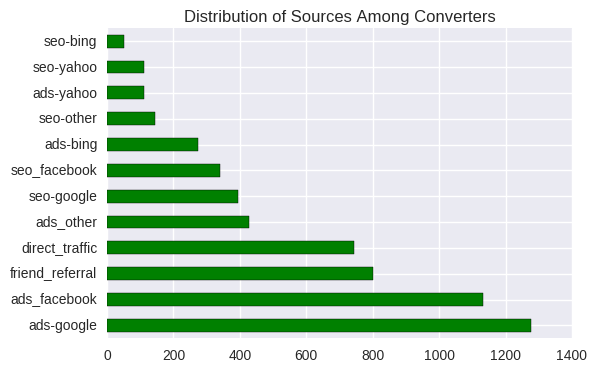

In [46]:
#Plot distribution for converters
CountStatus2 = pd.value_counts(df_bought['source'].values, sort=True)
CountStatus2 [0:13]

#plt.rcdefaults()
fig, ax = plt.subplots()
bar2 = CountStatus2.plot.barh(color = "green")
ax.set_title("Distribution of Sources Among Converters")

In [79]:
#See exact percentage of sources for converters
myseries2 = df_bought['source']
counts = myseries2.value_counts()
percent = (counts/len(df_bought['source']))*100
test4 = pd.concat([counts, percent], axis=1)
test4.columns = ['counts','proportion']
test4

,counts,proportion
ads-google,1276,21.969697
ads_facebook,1132,19.490358
friend_referral,801,13.791322
direct_traffic,743,12.792700
ads_other,429,7.386364
seo-google,394,6.783747
seo_facebook,340,5.853994
ads-bing,274,4.717631
seo-other,145,2.496556
ads-yahoo,112,1.928375


In [80]:
#Create dataset for only those who did not buy software
df_nobought= df_merge[df_merge.converted == 0]
len(df_nobought)#310992

310992

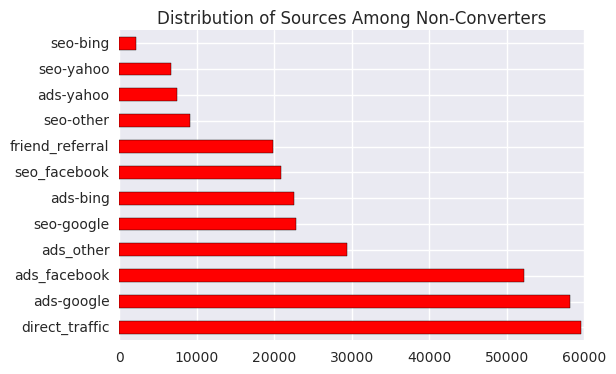

In [82]:
#Plot distribution of source for non-converters
%matplotlib inline
CountStatus3 = pd.value_counts(df_nobought['source'].values, sort=True)
#CountStatus3 [0:13]
#plt.rcdefaults()
fig, ax = plt.subplots()
bar3 = CountStatus3.plot.barh(color = "red")
ax.set_title("Distribution of Sources Among Non-Converters")
#sns.countplot(y="source", data=df_merged)

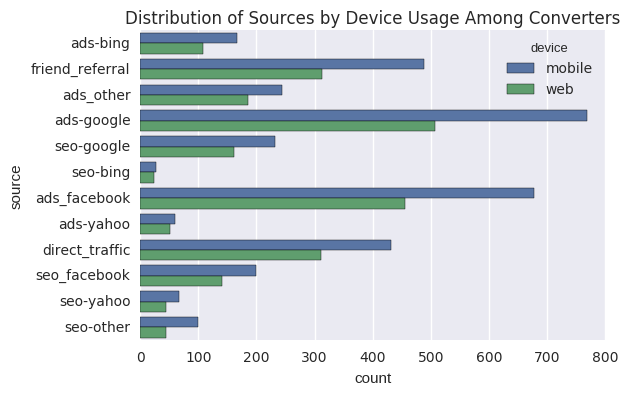

In [83]:
###Try another method of plotting bar plot using seaborn
#sns.countplot(x="device", data=df_merge, hue = "converted");
%matplotlib inline
#df_new = df_merge[['source','converted']]
#df_new
#sns.barplot(data = df_new)

sns.countplot(y="source", hue="device", data=df_bought)
plt.title('Distribution of Sources by Device Usage Among Converters')

In [114]:
#See exact percentage of mobile devices for converters
myseries3 = df_bought['device']
counts = myseries3.value_counts()
percent = (counts/len(df_bought['device']))*100
test5 = pd.concat([counts, percent], axis=1)
test5.columns = ['counts','proportion']
test5

,counts,proportion
mobile,3460,59.573003
web,2348,40.426997


In [115]:
#check to make sure numbers in above table match
pd.value_counts(df_bought.device)

mobile    3460
web       2348
Name: device, dtype: int64

In [72]:
df_no_missing = df_merge.dropna()
df_no_missing.head()
df_no_missing['country']
pd.value_counts(df_no_missing.country) #all buyers are from US

USA    275616
Name: country, dtype: int64

In [118]:
#Create a frequency table showing the proportion and counts
df_bought_nomiss = df_no_missing.loc[(df_no_missing['converted'] == 1)]
myseries = df_bought_nomiss['city']
counts = myseries.value_counts()
len(df_bought_nomiss['city'])
percent = (counts/5019)*100
test3 = pd.concat([counts, percent], axis=1)
test3.columns = ['counts','proportion']
test3[:10] #9% of those who converted were from NYC, followed by Houston and Chicago at 2% each

,counts,proportion
New York,443,8.826459
Houston,120,2.390915
Chicago,101,2.012353
San Antonio,85,1.693564
Los Angeles,79,1.574019
Austin,63,1.255230
San Jose,58,1.155609
Philadelphia,46,0.916517
Jacksonville,45,0.896593
Indianapolis,45,0.896593


### Answer to Question 2: Overall, those who bought the software accessed the site in the United States, with the majority of users in New York City (8.8%), Houston (2.4%), and Chicago (2.0%). Users predominately accessed the site using mobile devices (59%), and came to the site mostly via ads such as those on Google (22%) and Facebook (19%). Friend referral (14%) as well as direct traffic (13%) were other top sources for those who bought the software.

In [55]:
###Calculate sample number needed to detect significant difference between p1=0.0155 and p2=0.0199 at alpha=0.05 and beta=0.8

from scipy.stats import norm, zscore

def sample_power_probtest(p1, p2, power=0.8, sig=0.05):
    z = norm.isf([sig/2]) #two-sided t test
    zp = -1 * norm.isf([power]) 
    d = (p1-p2)
    s =2*((p1+p2) /2)*(1-((p1+p2) /2))
    n = s * ((zp + z)**2) / (d**2)
    return int(round(n[0]))

def sample_power_difftest(d, s, power=0.8, sig=0.05):
    z = norm.isf([sig/2])
    zp = -1 * norm.isf([power])
    n = s * ((zp + z)**2) / (d**2)
    return int(round(n[0]))

if __name__ == '__main__':

    n = sample_power_probtest(0.0155, 0.0199, power=0.8, sig=0.05)
    print n  #14098


14098


### Bonus: If only based on conversion rate, the study could have ended earlier based on the power analysis. However, this problem is a bit more complicated in that the average revenue per person must be greater in non-testers vs testers. I would recalculate the power with this in mind if I had more time.